In [1]:
from baselines import ValueDirected, ThompsonSampling, UCB, Greedy, Optimal
import gym
import envs.bandits
import numpy as np
import torch
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from models.probit import LaplaceProbitRegression
from utils import load_csv, kalman_filter

/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
num_episodes = 10000
num_steps = 10

mean_var = 100
reward_var = 10

baselines = [ValueDirected(), ThompsonSampling(), UCB()]

env = gym.make('GaussianBandit-v1')
env.batch_size = 1

probit_regression = np.zeros((len(baselines) + 1, 3))
probit_stds = np.zeros((len(baselines) + 1, 3))
regrets = np.zeros(len(baselines))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# compute regression coefficients for baselines
for b, baseline in enumerate(baselines):
    X = np.zeros((num_episodes * num_steps, 3))
    C = np.zeros((num_episodes * num_steps,))
    
    for i in range(num_episodes):
        priors = np.zeros((2, 2))
        priors[:, 1] = mean_var

        obs = env.reset()
            
        for j in range(num_steps):
            action = baseline.act(priors)
            
            action = torch.empty(1).fill_(np.random.binomial(1, action)).long()
            
            V = priors[1, 0] - priors[0, 0]
            Sm = math.sqrt(priors[1, 1]) - math.sqrt(priors[0, 1])
            S = math.sqrt(priors[1, 1] + priors[0, 1])
            X[i*num_steps+j, :] = np.array([V, Sm, V/S])
            C[i*num_steps+j] = action.item()
            
            obs, reward, _, info = env.step(action)
            regrets[b] += info['regrets'].item()
            alpha = (priors[int(action), 1]) / (priors[int(action), 1] + reward_var)
            priors[int(action), 0] = priors[int(action), 0] + alpha * (reward.item() - priors[int(action), 0])
            priors[int(action), 1] = priors[int(action), 1] - alpha * priors[int(action), 1]
            
    
    # probit regression
    pr = LaplaceProbitRegression(3)
    probit_regression[b, :] = pr.fit(X, C)
    probit_stds[b, :] = pr.hessian(X, C)
    
print(regrets / num_episodes)

[13.55897486 14.6819523  11.13927433]


In [4]:
# compute regression coefficients for best model
N, t, model = torch.load('trained_models/infty/0.pt')
model_samples = 1

X = np.zeros((num_episodes * num_steps, 3))
C = np.zeros((num_episodes * num_steps,))

for i in tqdm(range(num_episodes)):
    priors = np.zeros((2, 2))
    priors[:, 1] = mean_var

    obs = env.reset()
    
    hx = [model.initial_states(1) for k in range(model_samples)]
    zeta = [model.get_zeta(1) for k in range(model_samples)]
       
    for j in range(num_steps):
        
        action = 0
        for k in range(model_samples):
            q_mu, _, hx[k] = model(obs, hx[k], zeta[k])      
            action += torch.argmax(q_mu[0]).float().item()
        action = torch.empty(1).fill_(action / model_samples).round().long()   
        
            
        V = priors[1, 0] - priors[0, 0]
        Sm = math.sqrt(priors[1, 1]) - math.sqrt(priors[0, 1])
        S = math.sqrt(priors[1, 1] + priors[0, 1])
        X[i*num_steps+j, :] = np.array([V, Sm, V/S])
        C[i*num_steps+j] = action.item()
            
        obs, reward, _, _ = env.step(action)
            
        alpha = (priors[int(action), 1]) / (priors[int(action), 1] + reward_var)
        priors[int(action), 0] = priors[int(action), 0] + alpha * (reward.item() - priors[int(action), 0])
        priors[int(action), 1] = priors[int(action), 1] - alpha * priors[int(action), 1]
            
    
# probit regression
pr = LaplaceProbitRegression(3)
probit_regression[-1, :] = pr.fit(X, C)
probit_stds[-1, :] = pr.hessian(X, C)

/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.mdlrdqn.MDLRDQN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.recurrent.GroupHSGRUCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.linear.LinearGroupHS' has changed. you can retrieve the original source code b

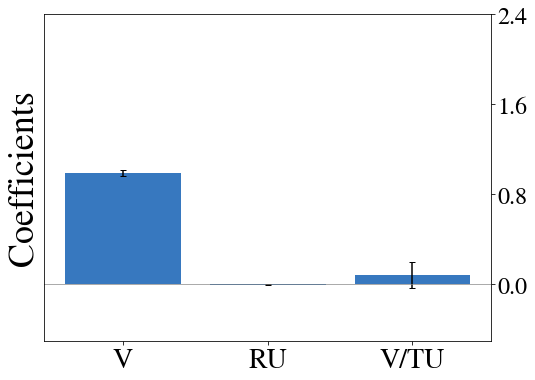

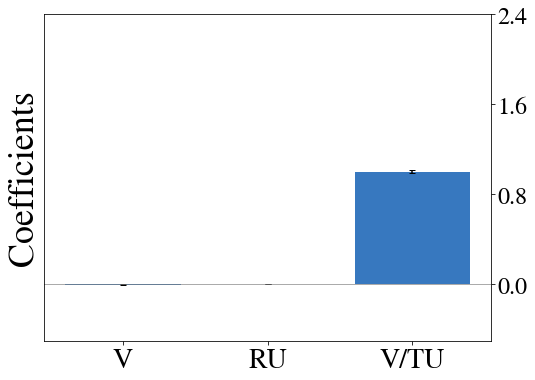

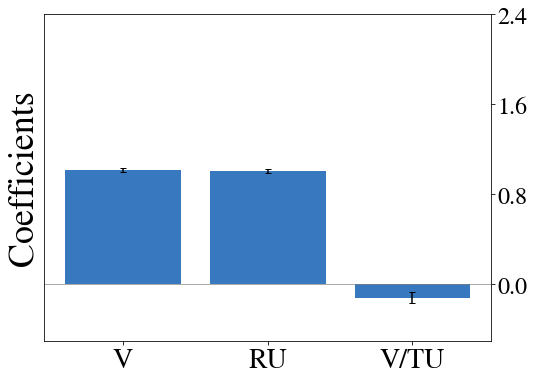

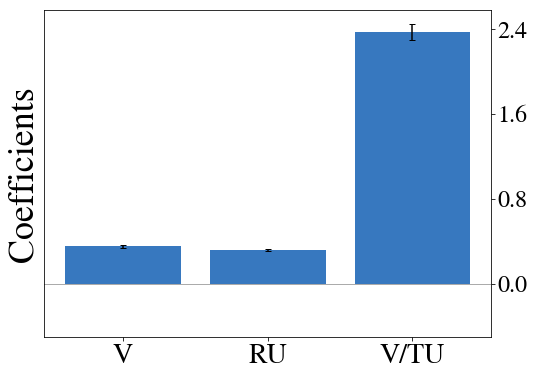

In [5]:
# plot regression coefficients (Figure 1)
plt.rcParams["figure.figsize"] = (8.0, 6.0)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


for i in range(probit_regression.shape[0]):
    plt.xticks(np.arange(3), ['V', 'RU', 'V/TU'], fontsize=28 )
    plt.ylim(-0.5, np.max(probit_regression[i, :]) + 0.2)
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')
    plt.yticks([0.0, 0.8, 1.6, 2.4], [0.0, 0.8, 1.6, 2.4], fontsize=24)
    plt.bar(np.arange(3), probit_regression[i, :], yerr=probit_stds[i, :], color=sns.xkcd_rgb["windows blue"], align='center', ecolor='black', capsize=3)
    plt.axhline(y=0,linewidth=1, color='grey', alpha=0.66)
    plt.ylabel('Coefficients', fontsize=36)
    plt.savefig(str(i) + '.pdf', bbox_inches='tight')
    plt.show()

In [11]:
model_samples = 100 # for more accurate results: 100
use_soft = False

policies = [256, 512, 1024, 2048, 4096, 8192, 16384] 
num_models = 10 # for more accurate results: 10

num_episodes = 1000
num_steps = 10

env = gym.make('GaussianBandit-v1')
env.batch_size = 1

regrets = np.zeros((len(policies), num_models))
probit_regression = np.zeros((len(policies), num_models, 3))


for n, policy in enumerate(policies):
    for i in range(num_models):
        load_path = 'trained_models/models_0911/' + str(policy) + '/soft_' + str(i+1) + '_0.pt' if use_soft else 'trained_models/models_0911/' + str(policy) + '/' + str(i+1) + '_0.pt'
        N, t, model = torch.load(load_path)
        
        X = np.zeros((num_episodes * num_steps, 3))
        C = np.zeros((num_episodes * num_steps,))

        for j in tqdm(range(num_episodes)):

            priors = np.zeros((2, 2))
            priors[:, 1] = mean_var

            obs = env.reset()
            
            hx = [model.initial_states(env.batch_size) for k in range(model_samples)]
            zeta = [model.get_zeta(env.batch_size) for k in range(model_samples)]

            for k in range(num_steps):
                
                action_model = 0
                if use_soft:
                    for m in range(model_samples):
                        _, hx[m], action_sample = model.act(obs, hx[m], zeta[m])
                        action_model += action_sample.item()
                else:
                    # TODO: if new models for rdqn are trained, we do not need to distinguish anymore
                    for m in range(model_samples):
                        q_mu, _, hx[m] = model(obs, hx[m], zeta[m])
                        action_model += torch.argmax(q_mu[0]).float().item()
                    
                
 
                action_model = action_model / model_samples
                action = torch.ones(1).long() if action_model > 0.5 else torch.zeros(1).long()
                
                V = priors[1, 0] - priors[0, 0]
                Sm = math.sqrt(priors[1, 1]) - math.sqrt(priors[0, 1])
                S = math.sqrt(priors[1, 1] + priors[0, 1])
                X[j*num_steps+k, :] = np.array([V, Sm, V/S])
                C[j*num_steps+k] = action.item()
                
                obs, reward, _, info = env.step(action)
                regrets[n, i] += info['regrets'].item()
                
                alpha = (priors[int(action), 1]) / (priors[int(action), 1] + reward_var)
                priors[int(action), 0] = priors[int(action), 0] + alpha * (reward.item() - priors[int(action), 0])
                priors[int(action), 1] = priors[int(action), 1] - alpha * priors[int(action), 1]
                
        # probit regression
        pr = LaplaceProbitRegression(3)
        probit_regression[n, i, :] = pr.fit(X, C)
        
# save regrets and regression coefficients
np.save('data/model_regrets.npy', regrets)
np.save('data/model_coefficients.npy', probit_regression)

/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.mdlrdqn.MDLRDQN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.linear.LinearGroupHS' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
  0%|          | 0/1000 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.recurrent.GroupHSGRUCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]


In [12]:
# load in human data
Q = [10, 100, 100]
current_data = load_csv('data/data2.csv')
latents_human = np.empty((1, len(current_data)), dtype=object)
regrets_human = np.zeros((len(current_data)))
b_human = np.zeros((len(current_data), 3))

for s in range(len(current_data)):
    latents_human[0, s] = kalman_filter(Q, current_data[0, s])
    

for s in range(latents_human.shape[1]):
    S = np.sqrt(latents_human[0, s]['s'][:, 0] + latents_human[0, s]['s'][:, 1])
    Sm = np.sqrt(latents_human[0, s]['s'][:, 0]) - np.sqrt(latents_human[0, s]['s'][:, 1])
    V = latents_human[0, s]['m'][:, 0] - latents_human[0, s]['m'][:, 1]
    C = (current_data[0, s]['c'] == 1)[:, 0].astype(float)
    X = np.stack([V, Sm, V/S]).T
    pr = LaplaceProbitRegression(3)
    b_human[s, :] = pr.fit(X, C)
    for idx in range(current_data[0, s]['R'].shape[0]):
        regrets_human[s] += 0 if current_data[0, s]['R'][idx, 1-int(C[idx])] > current_data[0, s]['R'][idx, int(C[idx])] else current_data[0, s]['R'][idx, int(C[idx])] - current_data[0, s]['R'][idx, 1-int(C[idx])] 
    
regrets_human = regrets_human / 20
print(regrets_human.mean())

11.280681818181817


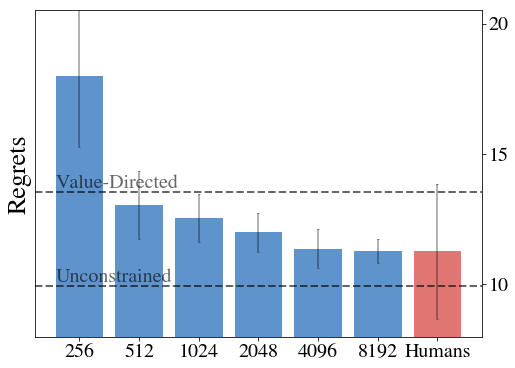

In [13]:
# plot the average regrets (Figure 2a)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

means = np.mean(regrets / num_episodes, axis=1) 
stds = np.std(regrets / num_episodes, axis=1)
means[-1] = regrets_human.mean()
stds[-1] = regrets_human.std()
policies[-1] = 'Humans'
#print(stds)

plt.xticks(np.arange(len(policies)), policies, fontsize=20)
plt.bar(np.arange(means.shape[0]), means, error_kw=dict(alpha=0.4), yerr=stds, alpha=0.8, capsize=1, color=[sns.xkcd_rgb["windows blue"]] * 6 + [sns.xkcd_rgb["pale red"]])
plt.ylabel('Regrets', size=26)
plt.ylim([8, 20.5])
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')
plt.axhline(13.55233531, linestyle='--', color='black', alpha=0.6, linewidth=2)
plt.axhline(9.927785222679377, linestyle='--', color='black', alpha=0.6, linewidth=2)
plt.yticks([10, 15, 20], [10, 15, 20], fontsize=20)
plt.text(-0.4, 10.09, 'Unconstrained', color='black', fontsize=20, alpha=0.6)
plt.text(-0.4, 13.72, 'Value-Directed', color='black', fontsize=20, alpha=0.6)

plt.savefig('regrets.pdf', bbox_inches='tight')

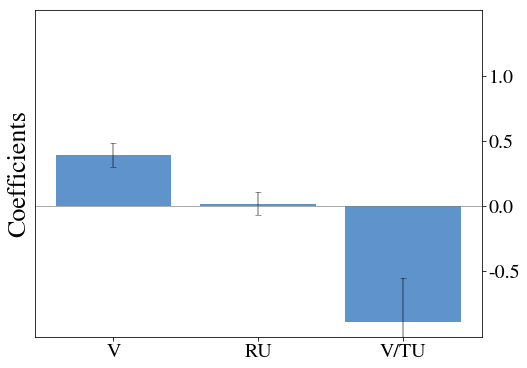

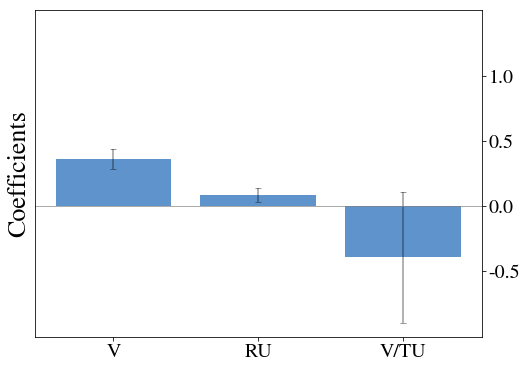

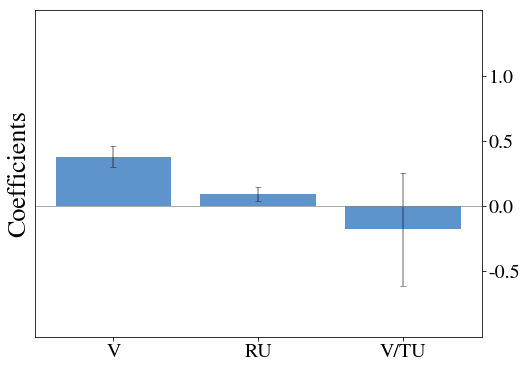

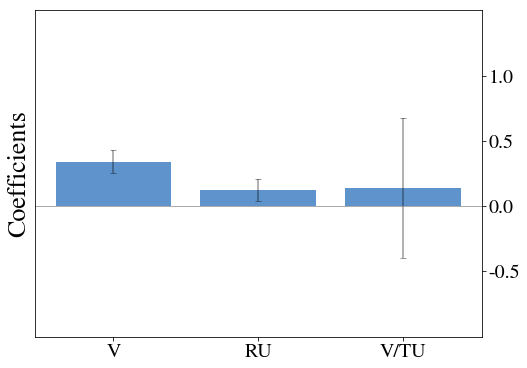

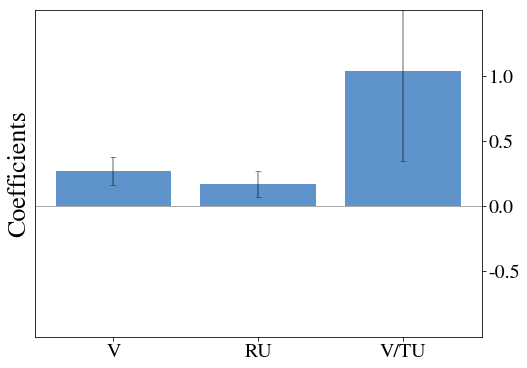

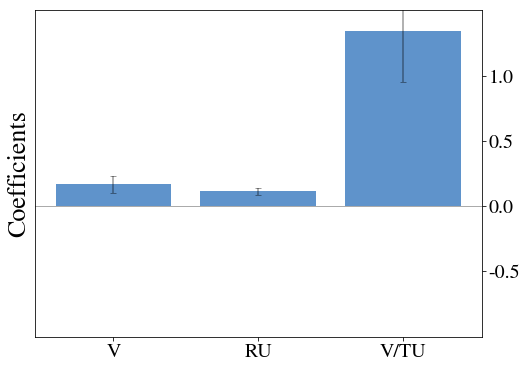

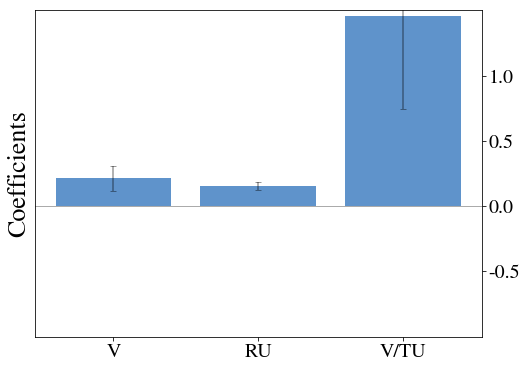

In [14]:
# plot coefficients for models (Figure 2b)
plt.rcParams["figure.figsize"] = (8.0, 6.0)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

for i in range(len(policies)):
    
    means = np.mean(probit_regression[i,:, :], axis=0)
    stds = np.std(probit_regression[i,:, :], axis=0)

    plt.xticks(np.arange(3), ['V', 'RU', 'V/TU'], fontsize=20 )
    plt.ylim([-1.0, 1.5])
    plt.yticks([-0.5, 0.0, 0.5, 1.0], [-0.5, 0.0, 0.5, 1.0], fontsize=20)
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')
    plt.bar(np.arange(3), means, color=sns.xkcd_rgb["windows blue"], error_kw=dict(alpha=0.4), alpha=0.8, yerr=stds, align='center', ecolor='black', capsize=3)
    plt.axhline(y=0,linewidth=1, color='grey', alpha=0.66)
    plt.ylabel('Coefficients', fontsize=26)
    plt.savefig(str(i) + 'models.pdf', bbox_inches='tight')
    plt.show()
    